# LINEAR GRAMMAR

Linear grammar is based on LinearGrammarV2 and LinearTranslator

### GENERATE A RANDOM NETWORK

This grammar works with a set of production rules which generate a random network without specifying dimensions such as number of features for each layer.

The user must specify the desired number of layers in the network.

Tree construction is sequential and follows these simple rules:
1) First node is always \<start\>
2) If previous node is \<start\>, sampled node can only be linear
3) If previous node is linear, sampled node can be, with same probability, linear or dropout
4) If previous node is dropout, sampled node can only be linear
5) Last node is always <end>

In [1]:
from cfg_nas.LinearGrammarV2 import LinearProductionRules

n_layers = 7

production_rules = LinearProductionRules(n_layers=n_layers)

empty_tree = production_rules.grow_tree()

for node in empty_tree:
    print(node)

['<start>', None, None]
['linear', None, None]
['dropout', None, None]
['linear', None, None]
['dropout', None, None]
['linear', None, None]
['linear', None, None]
['linear', None, None]
['<end>', None, None]


### FILL THE RANDOM NETWORK

Class __LinearGrammar__ does two things:
1) Generates an empty tree (as before)
2) Fill empty tree entries with reasonable values

It needs as parameters:
- Input dimension (number of features of input data)
- Output dimension (ex. 1 could be regression or binary classification)
- Number of Layers
- hidden\_in (number of output channels for the first linear)
- hidden\_out (number of output channels for last linear)

Setting layers parameters follows some rules:

__\<start\>__: this node is filled in the first position with the number of _features of input data_

__linear__: linear modules number of features are set such that there is linear convergence from _hidden\_in_ to _hidden\_out_. In first position we can find number of _output neurons_ while second dimension is empty.

__dropout__: _dropout percentage_ is randomly sampled from a Beta with most of the probability mass concentrated in values lower than 0.5. This percenage can be found in first position while second position is empty

__\<end\>__: this node is the final dense layer, which outputs objective number of features. This quantity is found in first position while second is empty.

In [2]:
from cfg_nas.LinearGrammarV2 import LinearGrammar

lingram = LinearGrammar(input_dim=64,
                        output_dim=1,
                        n_layers=5,
                        hidden_in=256,
                        hidden_out=8)

net = lingram.produceNetwork()
for layer in net:
    print(layer)

('<start>', 64, None)
('linear', 256, None)
('linear', 194, None)
('dropout', 0.22746386905861743, None)
('linear', 70, None)
('linear', 8, None)
('<end>', 1, None)


### TRANSLATE THE MODEL INTO A TORCH WORKING MODEL

In order to translate previous network to a working pytorch architecture, we need to pass it to TranslatedNetwork, which only needs the specification of the last activation and the type of all inner activations.

In [3]:
from cfg_nas.LinearTranslator import TranslatedNetwork
from torch import nn

model = TranslatedNetwork(network_tree=net,
                          default_activation=nn.ReLU(),
                          default_final_activation=nn.Sigmoid())

print(model.model)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=194, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.22746386905861743, inplace=False)
  (5): Linear(in_features=194, out_features=70, bias=True)
  (6): ReLU()
  (7): Linear(in_features=70, out_features=8, bias=True)
  (8): ReLU()
  (9): Linear(in_features=8, out_features=1, bias=True)
  (10): Sigmoid()
)


## WORKING EXAMPLE - IRIS, 50 RANDOM NETWORKS EVALUATION

In [4]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('C:\\Users\\drikb\\Desktop\\Candelieri Project\\CFG NAS\\data\\iris.csv')
data = data[data.columns[1:]]

train_data, test_data = train_test_split(data, stratify=data['Species'])

train_x, train_y = train_data[train_data.columns[:-1]].to_numpy(), train_data[train_data.columns[-1]].to_numpy()
test_x, test_y = test_data[test_data.columns[:-1]].to_numpy(), test_data[test_data.columns[-1]].to_numpy()

label_encoder = LabelEncoder()
label_encoder.fit(train_y)
train_y = label_encoder.transform(train_y)
test_y = label_encoder.transform(test_y)

# One vs. all
train_y = train_y == 0
test_y = test_y == 0

dtype = torch.float32
train_x, train_y, test_x, test_y = torch.tensor(train_x, dtype=dtype), torch.tensor(train_y, dtype=dtype), torch.tensor(test_x, dtype=dtype), torch.tensor(test_y, dtype=dtype)
train_y = train_y.unsqueeze(-1)
test_y = test_y.unsqueeze(-1)

In [5]:
lingram = LinearGrammar(input_dim=4,
                        output_dim=1,
                        n_layers=5,
                        hidden_in=256,
                        hidden_out=8)

default_activation = nn.ReLU()
default_final_activation = nn.Sigmoid()

networks = []
for i in range(50):
    network_tree = lingram.produceNetwork()
    networks.append(TranslatedNetwork(network_tree=network_tree,
                                      default_activation=default_activation,
                                      default_final_activation=default_final_activation))

In [6]:
from cfg_nas.Trainer import AutoTrainer
from torch.optim import AdamW

auto_trainer = AutoTrainer(train_data=train_x,
                           train_labels=train_y,
                           test_data=test_x,
                           test_labels=test_y,
                           criterion=nn.BCELoss(reduction='sum'),
                           optimizer=AdamW,
                           num_epochs=100,
                           lr=0.01,
                           batch_size=64)

In [7]:
performance_list = {'avg_train_loss' : [],
                    'avg_test_loss' : [],
                   'test_accuracy' : []}

for network in networks:
    avg_test_loss, avg_train_loss, test_accuracy = auto_trainer.train(network)
    performance_list['avg_train_loss'].append(avg_train_loss)
    performance_list['avg_test_loss'].append(avg_test_loss)
    performance_list['test_accuracy'].append(test_accuracy)


100%|██████████| 100/100 [00:01<00:00, 81.97it/s]


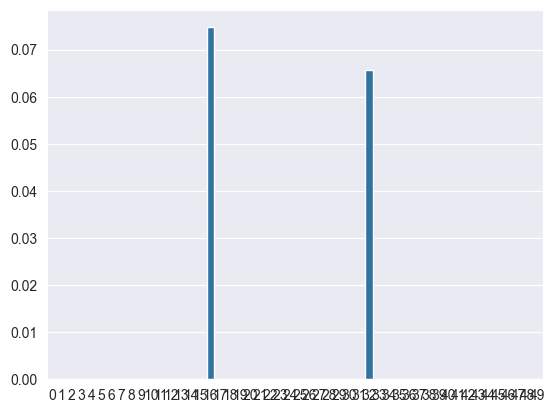

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(performance_list['avg_test_loss'])
plt.show()

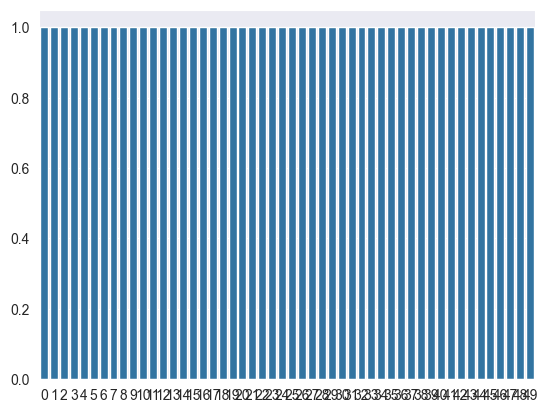

In [9]:
sns.barplot(performance_list['test_accuracy'])
plt.show()